In [1]:
import zipfile
import scipy.io
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
import mne
import torch
from torchvision import datasets, transforms
import sys
sys.path.insert(0,'/scratch/mcesped/code/NoiseDetection_iEEG/interictal_classifier/')

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"

## Tmp functions

In [51]:
# Custom transform
class RandomMask(object):
    """Masks randomly the spectrogram in a sample.
    3 masks in freq and 2 in time.
    https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-022-01942-2

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(
        self,
        p: float,
        f_max_size: int = 10,
        t_max_size: int = 10,
        n_masks_f: int = 3,
        n_masks_t: int = 3,
    ):
        assert isinstance(p, (float, int)) & (p <= 1) & (p >= 0)
        self.p = p
        self.f_max = f_max_size
        self.t_max = t_max_size
        self.n_masks_f = n_masks_f
        self.n_masks_t = n_masks_t

    def __call__(self, image):
        # print(image.shape)
        h, w = image.shape[-2:]

        image_out = np.copy(image)
        # Execute given a certain probability
        if np.random.random() < self.p:
            # Masks in freq
            for i in range(self.n_masks_f):
                # Mask goes from f_0 to f_0+f
                f = np.random.randint(low=1, high=self.f_max, size=1)[0]
                f_0 = np.random.randint(low=0.0, high=h - f, size=1)[0]
                # Update image
                image_out[..., f_0 : f_0 + f, :] = 0.0
            # Masks in time
            for j in range(self.n_masks_t):
                # Mask goes from t_0 to t_0+t
                t = np.random.randint(low=1, high=self.t_max, size=1)[0]
                t_0 = np.random.randint(low=0.0, high=w - t, size=1)[0]
                # print(t_0,t)
                # Update image
                image_out[..., :, t_0 : t_0 + t] = 0.0

        return torch.from_numpy(image_out).type(torch.float)

## 1. Get DataLoaders

In [10]:
import data_setup
import utils

In [36]:
# Zip files and transforms
features = 'Hilbert'
srate=2048
zip_files = [
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Fnusa_{features}.zip",
    f"/home/mcesped/scratch/Datasets/{srate}Hz/Dataset_Mayo_{features}.zip",
]
df_train_path = '/scratch/mcesped/Datasets/df_train_curated.csv'
df_val_path = '/scratch/mcesped/Datasets/df_val_curated.csv'
import utils
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    utils.RandomMask(p=1, f_max_size= 1, t_max_size = int(0.15*6094), n_masks_f=2, n_masks_t=3),
])

In [37]:
dir_save = '/home/mcesped/scratch/code/NoiseDetection_iEEG/notebooks'
(
        train_dataloader,
        val_dataloader,
        _,
    ) = data_setup.create_dataloaders_uncompress(
        zip_files,
        df_train_path,
        df_val_path,
        train_transform,
        None,
        batch_size=32,
        num_workers=4,
        dataset_class="SpectrogramDir",
        binary=True,
        previosly_uncompressed = True
    )
train_dataloader, val_dataloader 

Grouping Pathology and physiology in one class

[1 0 0 ... 0 1 1]
tensor([2.5084e-05, 4.1098e-05])

Creating dataset classes...


(<torch.utils.data.dataloader.DataLoader at 0x2aadda2eead0>,
 <torch.utils.data.dataloader.DataLoader at 0x2aadda36be80>)

In [38]:
# Check out single image size/shape
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([32, 1, 5, 6144]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])


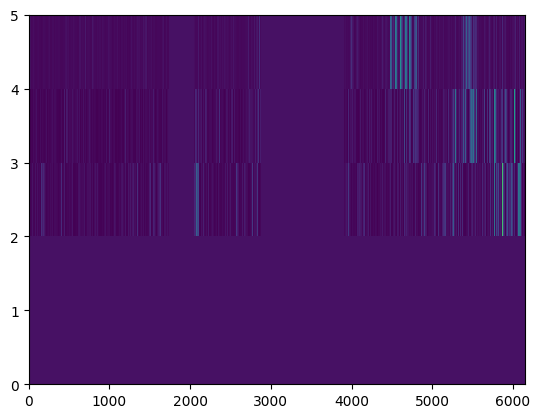

In [46]:
plt.pcolormesh(img[29,:,:,:].squeeze())

torch.Size([32, 5, 100, 100]) tensor(3)
torch.Size([32, 5, 100, 100]) tensor(3)
torch.Size([32, 5, 100, 100]) tensor(3)
torch.Size([32, 5, 100, 100]) tensor(3)
torch.Size([32, 5, 100, 100]) tensor(3)


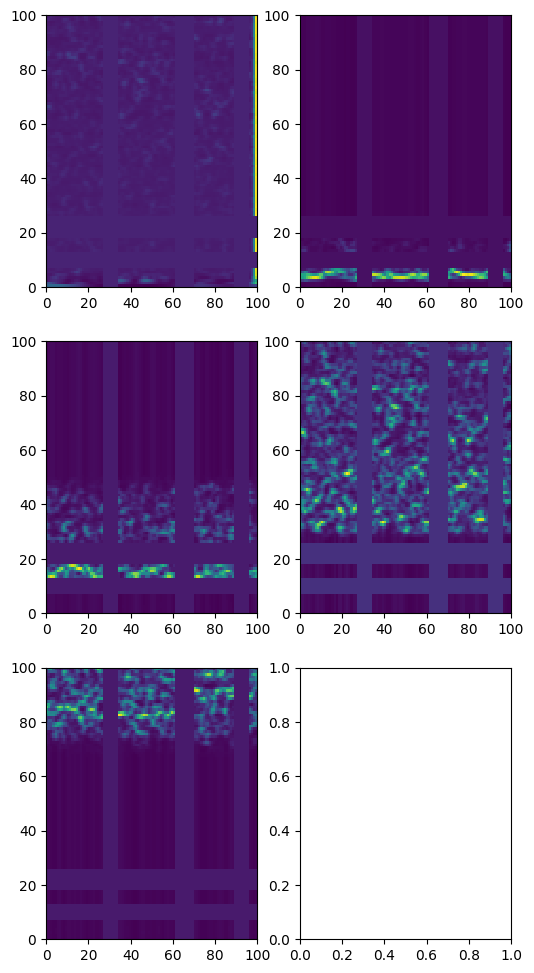

In [22]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(6,12))
n=4
for i, ax in enumerate(axes.flat):
    # image_torch = torch.from_numpy(np.expand_dims(image, axis=0))
    # ax.pcolormesh(train_transforms(image_torch).squeeze())
    if i < 5:
        ax.pcolormesh(img[n,i,:,:])
        print(img.shape, label[n])

torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)
torch.Size([32, 8, 30, 100]) tensor(1)


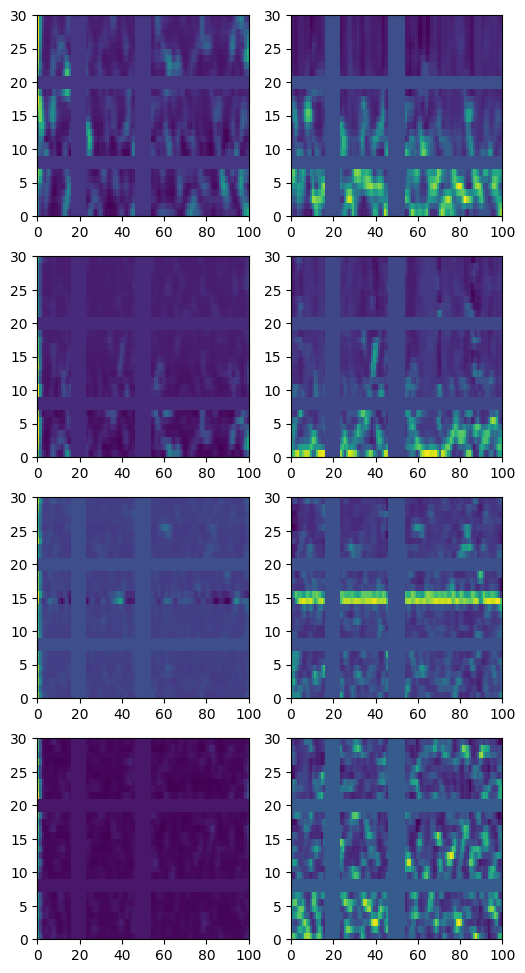

In [49]:
fig, axes = plt.subplots(ncols=2, nrows=4, figsize=(6,12))
n=9
img_tfm = test_transform(img)
for i, ax in enumerate(axes.flat):
    # image_torch = torch.from_numpy(np.expand_dims(image, axis=0))
    # ax.pcolormesh(train_transforms(image_torch).squeeze())
    ax.pcolormesh(img_tfm[n,i,:,:])
    print(img.shape, label[n])

In [8]:
np.unique(label) # noise: 1, path: 2, physio: 3, poweline: 0. Path is the smallest class. Physio is the biggest

array([0, 1, 2, 3])

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# https://towardsdatascience.com/demystifying-pytorchs-weightedrandomsampler-by-example-a68aceccb452
def visualise_dataloader(dl, id_to_label=None, with_outputs=True):
    total_num_images = len(dl.dataset)
    idxs_seen = []
    class_0_batch_counts = []
    class_1_batch_counts = []
    class_2_batch_counts = []
    class_3_batch_counts = []

    for i, (X, y) in enumerate(dl):

        # idxs = batch[0][:, 0].tolist()
        classes = y
        class_ids, class_counts = classes.unique(return_counts=True)
        class_ids = set(class_ids.tolist())
        class_counts = class_counts.tolist()
        

        # idxs_seen.extend(idxs)

        if len(class_ids) == 4:
            class_0_batch_counts.append(class_counts[0])
            class_1_batch_counts.append(class_counts[1])
            class_2_batch_counts.append(class_counts[2])
            class_3_batch_counts.append(class_counts[3])
        if i==50:
            break
        # elif len(class_ids) == 1 and 0 in class_ids:
        #     class_0_batch_counts.append(class_counts[0])
        #     class_1_batch_counts.append(0)
        # elif len(class_ids) == 1 and 1 in class_ids:
        #     class_0_batch_counts.append(0)
        #     class_1_batch_counts.append(class_counts[0])
        # else:
        #     raise ValueError("More than two classes detected")

    if with_outputs:
        fig, ax = plt.subplots(1, figsize=(15, 15))

        ind = np.arange(len(class_0_batch_counts))
        width = 0.10

        ax.bar(
            ind,
            class_0_batch_counts,
            width,
            label=(id_to_label[0] if id_to_label is not None else "0"),
        )
        ax.bar(
            ind + width,
            class_1_batch_counts,
            width,
            label=(id_to_label[1] if id_to_label is not None else "1"),
        )
        ax.bar(
            ind + width*2,
            class_2_batch_counts,
            width,
            label=(id_to_label[2] if id_to_label is not None else "2"),
        )
        ax.bar(
            ind + width*3,
            class_3_batch_counts,
            width,
            label=(id_to_label[3] if id_to_label is not None else "3"),
        )
        ax.set_xticks(ind, ind+1)
        ax.set_xlabel("Batch index", fontsize=12)
        ax.set_ylabel("No. of images in batch", fontsize=12)
        ax.set_aspect("equal")

        plt.legend()
        plt.show()

        # num_images_seen = len(idxs_seen)

        # print(
        #     f'Avg Proportion of {(id_to_label[0] if id_to_label is not None else "Class 0")} per batch: {(np.array(class_0_batch_counts) / 10).mean()}'
        # )
        # print(
        #     f'Avg Proportion of {(id_to_label[1] if id_to_label is not None else "Class 1")} per batch: {(np.array(class_1_batch_counts) / 10).mean()}'
        # )
        # print("=============")
        # print(f"Num. unique images seen: {len(set(idxs_seen))}/{total_num_images}")
    return class_0_batch_counts, class_1_batch_counts#, idxs_seen

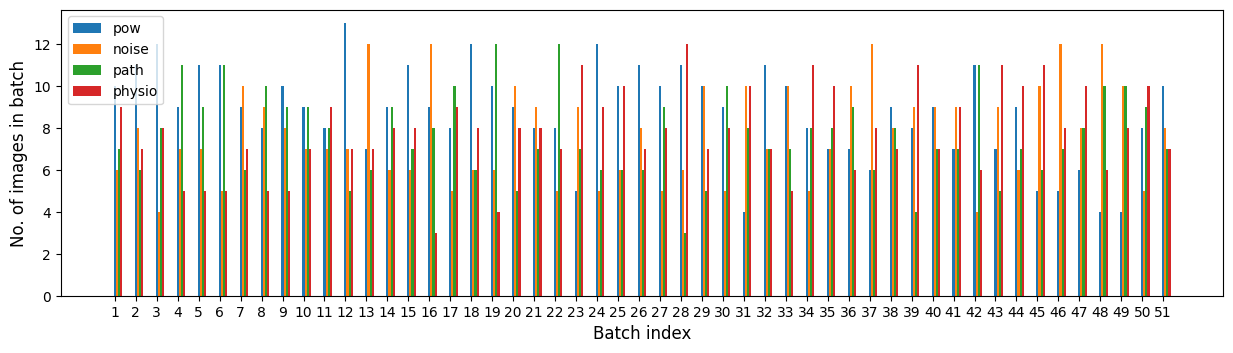

In [10]:
class_0_batch_counts, class_1_batch_counts = visualise_dataloader(train_dataloader, id_to_label=['pow', 'noise', 'path', 'physio'])

In [9]:
# Check validation dataset
y_total = np.array([])
for batch, (X, y) in enumerate(val_dataloader):
    y_total = np.concatenate([y_total, y])
    if batch % 100 == 0:
        print(batch, np.unique(y_total))

0 [1. 3.]
100 [1. 3.]
200 [1. 3.]
300 [1. 3.]


KeyboardInterrupt: 

In [9]:
val_dataloader.classes

AttributeError: 'DataLoader' object has no attribute 'classes'

In [10]:
y_total.shape, len(np.unique(y_total))

((9760,), 2)

## 2. Making the model

### 2.1. Custom model

In [4]:
import model

In [5]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
input_length = 6094
model_1 = model.CNN_Long_Data3(n_classes=4, input_size=1).to(device)
model_1

CNN_Long_Data3(
  (conv1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv3): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (conv4): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): AvgPool2d(kernel_size=(1, 2), stride=(1, 2), padding=0)
  )
  (fc1): Sequential(
    (0): F

In [6]:
from torchinfo import summary
summary(model_1, 
        input_size=(32, 1, 5, input_length), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
# SimpleCNN2: 35,516
# SimpleCNN: 73,236
# MultiLayerClassifier: 171,172
# MultiLayerCNN: 43,012
# MultiLayerCNNSmall: 80,260
# MultiLayerCNNSmall2: 2,651,512
# MultiLayerCNNTiny: 21,252
# custom_resnet34: 142,020

/local/mcesped.16410930.0/tmp/kslurm-venv-e5_gco7u/lib/python3.10/site-packages/torchinfo/torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
CNN_Long_Data3 (CNN_Long_Data3)          [32, 1, 5, 6094]     [32, 4]              --                   True
├─Sequential (conv1)                     [32, 1, 5, 6094]     [32, 64, 3, 3046]    --                   True
│    └─Conv2d (0)                        [32, 1, 5, 6094]     [32, 64, 3, 6092]    640                  True
│    └─BatchNorm2d (1)                   [32, 64, 3, 6092]    [32, 64, 3, 6092]    128                  True
│    └─ReLU (2)                          [32, 64, 3, 6092]    [32, 64, 3, 6092]    --                   --
│    └─MaxPool2d (3)                     [32, 64, 3, 6092]    [32, 64, 3, 3046]    --                   --
├─Sequential (conv2)                     [32, 64, 3, 3046]    [32, 64, 3, 3046]    --                   True
│    └─Conv2d (0)                        [32, 64, 3, 3046]    [32, 64, 3, 3046]    36,928               True
│    └─BatchNorm2d

**CNN_Long_Data**
*Parameters using Hilbert features (1 by 5 by 6144 input)*
- 6,142,684

**CNN_Long_Data2**
*Parameters using Hilbert features (1 by 5 by 6144 input)*
- 24,357,620

**CNN_Long_Data3**
*Parameters using Hilbert features (1 by 5 by 6144 input)*
- 100,101,956

In [5]:
# 1. Get a batch of images and labels from the DataLoader
# img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img[0].unsqueeze(dim=0), label[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
model_1.eval()
with torch.inference_mode():
    pred = model_1(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

NameError: name 'img' is not defined

In [22]:
print(model_1)

MultiLayerClassifier(
  (cnn1): Sequential(
    (0): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnn2): Sequential(
    (0): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (cnn_rect): Sequential(
    (0): Conv2d(32, 32, kernel_size=(30, 3), stride=(1, 1), padding=(0, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (gru): LSTM(32, 32, batch_first=True, dropout=0.5)
  (classifier): Linear(in_features=32, out_features=4, bias=True)
)


### 2.2. Pretrained model

In [4]:
import torch.nn as nn
from torchinfo import summary

In [5]:
from model import custom_resnet34
resnet_model = custom_resnet34(4).to(device)

In [6]:
summary(resnet_model, 
        input_size=(32, 1, 100, 100), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/local/mcesped.14443238.0/tmp/kslurm-venv-7wk3jkq5/lib/python3.10/site-packages/torchinfo/torchinfo.py:462: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
ResNet (ResNet)                          [32, 1, 100, 100]    [32, 4]              --                   Partial
├─Conv2d (conv1)                         [32, 1, 100, 100]    [32, 64, 96, 96]     1,664                True
├─BatchNorm2d (bn1)                      [32, 64, 96, 96]     [32, 64, 96, 96]     (128)                False
├─ReLU (relu)                            [32, 64, 96, 96]     [32, 64, 96, 96]     --                   --
├─MaxPool2d (maxpool)                    [32, 64, 96, 96]     [32, 64, 48, 48]     --                   --
├─Sequential (layer1)                    [32, 64, 48, 48]     [32, 64, 48, 48]     --                   False
│    └─BasicBlock (0)                    [32, 64, 48, 48]     [32, 64, 48, 48]     --                   False
│    │    └─Conv2d (conv1)               [32, 64, 48, 48]     [32, 64, 48, 48]     (36,864)             False
│    │    └

In [11]:
# 1. Get a batch of images and labels from the DataLoader
img_batch, label_batch = next(iter(train_dataloader))

# 2. Get a single image from the batch and unsqueeze the image so its shape fits the model
img_single, label_single = img_batch[0].unsqueeze(dim=0), label_batch[0]
print(f"Single image shape: {img_single.shape}\n")

# 3. Perform a forward pass on a single image
resnet_model.eval()
with torch.inference_mode():
    pred = resnet_model(img_single.to(device))
    
# 4. Print out what's happening and convert model logits -> pred probs -> pred label
print(f"Output logits:\n{pred}\n")
print(f"Output prediction probabilities:\n{torch.softmax(pred, dim=1)}\n")
print(f"Output prediction label:\n{torch.argmax(torch.softmax(pred, dim=1), dim=1)}\n")
print(f"Actual label:\n{label_single}")

Single image shape: torch.Size([1, 1, 100, 100])

Output logits:
tensor([[ 1.0641, -0.6338,  0.4723, -0.1970]])

Output prediction probabilities:
tensor([[0.4951, 0.0906, 0.2740, 0.1403]])

Output prediction label:
tensor([0])

Actual label:
1


## 3. Train and evaluate the model

In [5]:
import model
import data_setup
from engine import train
import torch.nn as nn

/local/mcesped.14443238.0/tmp/kslurm-venv-7wk3jkq5/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
# Zip files and transforms
zip_files = ['/home/mcesped/scratch/Datasets/Dataset_Fnusa_np.zip', '/home/mcesped/scratch/Datasets/Dataset_Mayo_np.zip']

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=1),
    transforms.Resize((100, 100), antialias=True)
])
val_transform = transforms.Compose([
    transforms.Resize((100, 100), antialias=True)
])

# Create dataloaders
train_dataloader, val_dataloader, class_names = data_setup.create_dataloaders(zip_files, train_transform, val_transform, batch_size=32, num_workers=16)
train_dataloader, val_dataloader, class_names 

(<torch.utils.data.dataloader.DataLoader at 0x2b1c9fdf04c0>,
 ['noise', 'pathology', 'physiology', 'powerline'])

In [ ]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 1

# Recreate an instance of TinyVGG
model_0 = model.custom_resnet34(4).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader,
                        test_dataloader=val_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS,
                        device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

# Save the model
# save_model(model=model_0,
#            target_dir="models",
#            model_name="05_going_modular_cell_mode_tinyvgg_model.pth")

  0%|          | 0/1 [00:00<?, ?it/s]

Accuracy training in batch 0: 0.1875
Accuracy training in batch 10: 0.25
Accuracy training in batch 20: 0.15625
Accuracy training in batch 30: 0.59375
Accuracy training in batch 40: 0.59375
Accuracy training in batch 50: 0.75
Accuracy training in batch 60: 0.5
Accuracy training in batch 70: 0.71875
Accuracy training in batch 80: 0.625
Accuracy training in batch 90: 0.71875
Accuracy training in batch 100: 0.5
Accuracy training in batch 110: 0.625
Accuracy training in batch 120: 0.53125
Accuracy training in batch 130: 0.625
Accuracy training in batch 140: 0.625
Accuracy training in batch 150: 0.71875
Accuracy training in batch 160: 0.71875
Accuracy training in batch 170: 0.5625
Accuracy training in batch 180: 0.625
Accuracy training in batch 190: 0.59375
Accuracy training in batch 200: 0.5625
Accuracy training in batch 210: 0.46875
Accuracy training in batch 220: 0.71875
Accuracy training in batch 230: 0.5625
Accuracy training in batch 240: 0.5625
Accuracy training in batch 250: 0.59375
